In [17]:
import pandas as pd
import numpy as np
import joblib
import time
import socket
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

%matplotlib inline

In [41]:
from sklearn.metrics import ndcg_score

def precision(actual, predicted, k):
    act_set = set(actual[:k])
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    
    return result
    
def evaluate_ranking(pred, test, k=5, exponential_scaling=False):    
    ndcg = []
    prec  = []
    for i, pred_row in pred.iterrows():
        test_row = test.loc[i]
        shared_drugs = list(set(pred_row.dropna().index) & set(test_row.dropna().index))
        test_row = test_row[shared_drugs]
        pred_row = pred_row[shared_drugs]
        
        pred_order = pred_row.sort_values().index.tolist()
        test_order = test_row.sort_values().index.tolist()
                        
        if len(shared_drugs) > 1:
            ndcg.append(ndcg_score([test_row.values], [pred_row.values], k=k))
            
        prec.append(precision(test_order, pred_order, k=k))
        
        
    return (np.mean(prec), np.mean(ndcg))

import scipy.stats
from sklearn.metrics import mean_squared_error

def evaluate_mse_pearson(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for i, row in pred.iterrows():
        p = row.dropna()
        g = gt.loc[i].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

def evaluate_mse_pearson_per_drug(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for drug in pred.columns:
        p = pred[drug].dropna()
        g = gt[drug].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

In [45]:
res_dir = 'predictions/GDSC'
split_dir = 'data/GDSC/splits'

viab_conditions = ['IC50', 'IC50_zscore', 'IC50_max_conc']
cv = 5
ks = [1,3,5,10,15,30]

ranking_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 'k', 
                            'prec', 'ndcg'])
mse_pearson_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval'])
mse_pearson_eval_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval'])
ranking_counter = 0
mp_counter = 0

for cond in notebook.tqdm(viab_conditions):
    if cond == 'IC50_zscore':
        cv_split_dir = os.path.join(split_dir, 'cv_splits_zscored')
    else: 
        cv_split_dir = os.path.join(split_dir, 'cv_splits')
    
    if cond == 'IC50_max_conc': postfix = '_max_conc'
    else: postfix = ''
        
    
    for split_nr in notebook.tqdm(range(0, cv), leave = False):
        #if cond != 'IC50': continue
        test_df_path  = cv_split_dir + '/cv_' + str(cv) + '/test_cv_' + str(cv)  +\
                            '_fold_' + str(split_nr) + postfix + '.csv'
        
        test_df = pd.read_csv(test_df_path, index_col = 0)
            
        cond_path = os.path.join(res_dir, cond)
        for model in os.listdir(cond_path):
            if model.startswith('.'): continue
                
            #if model != 'paccmann': continue
                 
            model_path = os.path.join(cond_path, model)
            for submodel in os.listdir(model_path):
                #if submodel != 'paccmann_mse': continue
                
                if submodel.startswith('.'): continue
                
                submodel_path = os.path.join(model_path, submodel)
                if submodel.endswith('zeros') or model == 'mean_baseline': 
                    rnaseq = 'no RNAseq'
                elif submodel.endswith('feat_sel'):
                    rnaseq = 'genes selected per drug'
                elif submodel.startswith('deepCDR'):
                    rnaseq = 'DeepCDR genes'
                else: 
                    rnaseq = 'PaccMann genes'
                    
                print(cond, model, submodel)
                prediction_df = None
                corr_test_df = None
                
                if model.endswith('feat_sel') or model == 'mean_baseline':
                    for pred_file in os.listdir(submodel_path):
                        if pred_file.startswith('.'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0)
                        
                        shared_cell_lines = list(set(prediction_df.index)&set(test_df.index))
                        corr_test_df = test_df.loc[shared_cell_lines]
                        prediction_df = prediction_df.loc[shared_cell_lines]
                        prediction_df = prediction_df.loc[corr_test_df.index][corr_test_df.columns]
                elif model.startswith('deepCDR'):
                    for pred_file in os.listdir(submodel_path):
                        if not pred_file.endswith(str(split_nr)+'.csv'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        data_df = pd.read_csv(prediction_path, index_col = 0)
                        data_df = data_df.sort_values('observation').drop_duplicates(['cell_line', 'drug']).sort_index()
                        prediction_df = data_df.pivot(index = 'cell_line', columns = 'drug', values = 'prediction')
                        corr_test_df = data_df.pivot(index = 'cell_line', columns = 'drug', values = 'observation')
                else:
                    for pred_file in os.listdir(submodel_path):
                        if not pred_file.endswith(str(split_nr)+'.csv'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0).loc[test_df.index][test_df.columns]
                    if model != 'knn': corr_test_df = (test_df.T.max() - test_df.T).T
                    else: corr_test_df = test_df
                                     
                (mse, pearsonr, pval) = evaluate_mse_pearson(prediction_df, corr_test_df)
                mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                    split_nr, mse, pearsonr, pval]
                (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(prediction_df, corr_test_df)
                mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                    split_nr, mse, pearsonr, pval]
                
                mp_counter += 1
                    
                for k in ks:
                    (prec, ndcg) = evaluate_ranking(prediction_df, corr_test_df, k = k)
                        
                    ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                        split_nr, k, np.mean(prec), np.mean(ndcg)]
                    ranking_counter += 1


            

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

IC50 deepCDR deepCDR
IC50 deepCDR deepCDR_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 knn knn_paccmann
IC50 knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse
IC50 deepCDR deepCDR
IC50 deepCDR deepCDR_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 knn knn_paccmann
IC50 knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse
IC50 deepCDR deepCDR
IC50 deepCDR deepCDR_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 knn knn_paccmann
IC50 knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse
IC50 deepCDR deepCDR
IC50 deepCDR deepCDR_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 knn knn_paccmann
IC50 knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse
IC50 deepCDR deepCDR
IC50 deepCDR deepCDR_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 knn knn_paccmann
IC50 knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50 baseline_nn nn_baseline_mse


  0%|          | 0/5 [00:00<?, ?it/s]

IC50_zscore deepCDR deepCDR_zscore
IC50_zscore deepCDR deepCDR_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore deepCDR deepCDR_zscore
IC50_zscore deepCDR deepCDR_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore deepCDR deepCDR_zscore
IC50_zscore deepCDR deepCDR_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore deepCDR deepCDR_zscore
IC50_zscore deepCDR deepCDR_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore deepCDR deepCDR_zscore
IC50_zscore deepCDR deepCDR_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore mean_baseline mean_baseline


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/5 [00:00<?, ?it/s]

IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IC50_max_conc paccmann_ndcg paccmann_approx_ndcg


In [36]:
from scipy import stats

pearsons = []
mses = []

for i, pred in prediction_df.iterrows():
    pred = pred.dropna()
    
    gs = test_df.loc[i]
    gs = gs.loc[pred.index]
    if len(pred) > 2:
        pearson = stats.pearsonr(gs, pred)
        pearsons.append(pearson[0])
        
    mse = mean_squared_error(gs, pred)
    mses.append(mse)
np.mean(mses)

80.88883562111532

In [101]:
counter = 0
ranking_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'k', 
                                      'prec', 'prec_std', 'prec_stderror',
                                      'ndcg', 'ndcg_std', 'ndcg_stderror'
                                   ])

for (model, drug_response, genes, k), rows in ranking_eval.groupby(['model', 'drug_response', 'genes', 'k']):
    ranking_res.loc[counter] = [model, drug_response, genes, k,
                              np.mean(rows.prec), np.std(rows.prec), np.std(rows.prec)/np.sqrt(len(rows.prec)),
                              np.mean(rows.ndcg), np.std(rows.ndcg), np.std(rows.ndcg)/np.sqrt(len(rows.ndcg))
                            ]
    counter+=1
ranking_res.to_csv('tables/results/GDSC/gdsc_ranking_results.csv')
ranking_res

,model,drug_response,genes,k,prec,prec_std,prec_stderror,ndcg,ndcg_std,ndcg_stderror
0,baseline_nn,IC50,PaccMann genes,1,0.141988,0.053945,0.024125,0.845929,0.017610,0.007875
1,baseline_nn,IC50,PaccMann genes,3,0.241472,0.049608,0.022185,0.858778,0.012241,0.005474
2,baseline_nn,IC50,PaccMann genes,5,0.251745,0.029012,0.012975,0.866646,0.010991,0.004915
3,baseline_nn,IC50,PaccMann genes,10,0.292441,0.032004,0.014312,0.874744,0.012687,0.005674
4,baseline_nn,IC50,PaccMann genes,15,0.346722,0.043145,0.019295,0.880621,0.012699,0.005679
...,...,...,...,...,...,...,...,...,...,...
151,paccmann_ndcg,IC50_zscore,no RNAseq,3,0.004872,0.003368,0.001506,0.456112,0.016868,0.007544
152,paccmann_ndcg,IC50_zscore,no RNAseq,5,0.009180,0.004669,0.002088,0.472228,0.015962,0.007138
153,paccmann_ndcg,IC50_zscore,no RNAseq,10,0.021300,0.005577,0.002494,0.500701,0.012750,0.005702
154,paccmann_ndcg,IC50_zscore,no RNAseq,15,0.040436,0.008998,0.004024,0.521946,0.012830,0.005738


In [46]:
counter = 0
mse_pearson_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean'])

for (model, drug_response, genes), rows in mse_pearson_eval.groupby(['model', 'drug_response', 'genes']):
    mse_pearson_res.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval)
                            ]
    counter+=1
mse_pearson_res.to_csv('tables/results/GDSC/gdsc_mse_pearson_per_cell_line.csv')
mse_pearson_res

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean
0,baseline_nn,IC50,PaccMann genes,7.108623,0.384793,0.172085,0.661693,0.047055,0.021043,1.715582e-03
1,baseline_nn,IC50,no RNAseq,3.330384,0.123396,0.055184,0.876901,0.005779,0.002584,2.302276e-10
2,baseline_nn,IC50_zscore,PaccMann genes,1.333119,0.085293,0.038144,-0.001337,0.010816,0.004837,3.458118e-01
3,baseline_nn,IC50_zscore,no RNAseq,1.120624,0.044823,0.020045,0.002018,0.027822,0.012442,3.013171e-01
4,deepCDR,IC50,DeepCDR genes,2.042660,0.106105,0.047452,0.882040,0.004068,0.001819,4.635977e-10
5,deepCDR,IC50,no RNAseq,2.144892,0.127681,0.057101,0.879746,0.005238,0.002343,2.706106e-10
6,deepCDR,IC50_zscore,DeepCDR genes,0.946770,0.034696,0.015517,0.152422,0.042658,0.019077,1.978429e-01
7,deepCDR,IC50_zscore,no RNAseq,1.030035,0.042251,0.018895,-0.006571,0.002477,0.001108,5.421090e-01
8,knn,IC50,PaccMann genes,3.697025,0.042615,0.019058,0.789994,0.004603,0.002059,1.540798e-09
9,knn,IC50,no RNAseq,3.687375,0.209334,0.093617,0.778948,0.012946,0.005789,9.462289e-09


In [90]:
def extract_metrics(mse_pearson, models):
    pearson = []
    pearson_err = []
    mse = []
    mse_err = []
    for model in models:
        row = mse_pearson[mse_pearson.model == model]
        if model == 'lin_reg_feat_sel': 
            row = row[row.genes != 'PaccMann genes']
        if len(row) == 0:
            pearson.append(0)
            pearson_err.append(0)
            mse.append(0)
            mse_err.append(0)
        else:
            pearson.append(row.pearson.values[0])
            pearson_err.append(row.pearson_std.values[0])
            mse.append(row.mse.values[0])
            mse_err.append(row.mse_std.values[0])
    return (pearson, pearson_err, mse, mse_err)

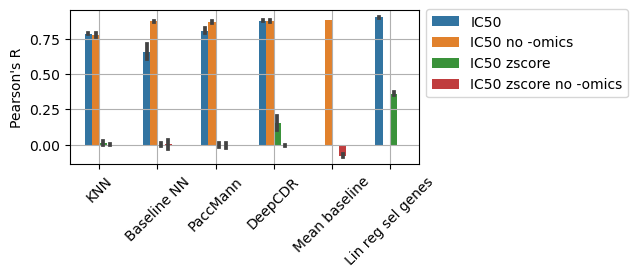

In [133]:
rel_mse_pearson_eval = mse_pearson_eval[(mse_pearson_eval.model.isin(['deepCDR', 'knn', 'mean_baseline', 
                                                                      'lin_reg_feat_sel', 'paccmann',
       'baseline_nn']) & mse_pearson_eval.drug_response.isin(['IC50', 'IC50_zscore']))]
rel_mse_pearson_eval = rel_mse_pearson_eval[(rel_mse_pearson_eval.model!='lin_reg_feat_sel')|(rel_mse_pearson_eval.genes!='PaccMann genes')]
rel_mse_pearson_eval = rel_mse_pearson_eval.replace({'deepCDR': 'DeepCDR', 'paccmann': 'PaccMann',
                                                   'baseline_nn': 'Baseline NN', 'mean_baseline': 'Mean baseline',
                                                   'lin_reg_feat_sel': 'Lin reg sel genes', 'knn': 'KNN',
                                                   'IC50_zscore': 'IC50 zscore'})
for (dr, g), rows in rel_mse_pearson_eval.groupby(['drug_response', 'genes']):
    if g == 'no RNAseq': rel_mse_pearson_eval.loc[rows.index, 'label'] = dr + ' no -omics'
    else: rel_mse_pearson_eval.loc[rows.index, 'label'] = dr
        

fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (4.5, 2))

sns.barplot(x="model", y="pearson", hue="label", data=rel_mse_pearson_eval, ax = axs, 
            width=0.5, errorbar = 'sd', 
            order=['KNN', 'Baseline NN', 'PaccMann', 'DeepCDR', 'Mean baseline', 'Lin reg sel genes'])


axs.set_ylabel("Pearson's R")
axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
axs.grid('horizontal')
axs.set_xlabel(None)

axs.legend(bbox_to_anchor=(1, 1.05), title=None)

plt.savefig('figures/results/GDSC/GDSC_models_pearson.png', facecolor = 'white', 
            transparent = False, dpi=500, bbox_inches='tight') 

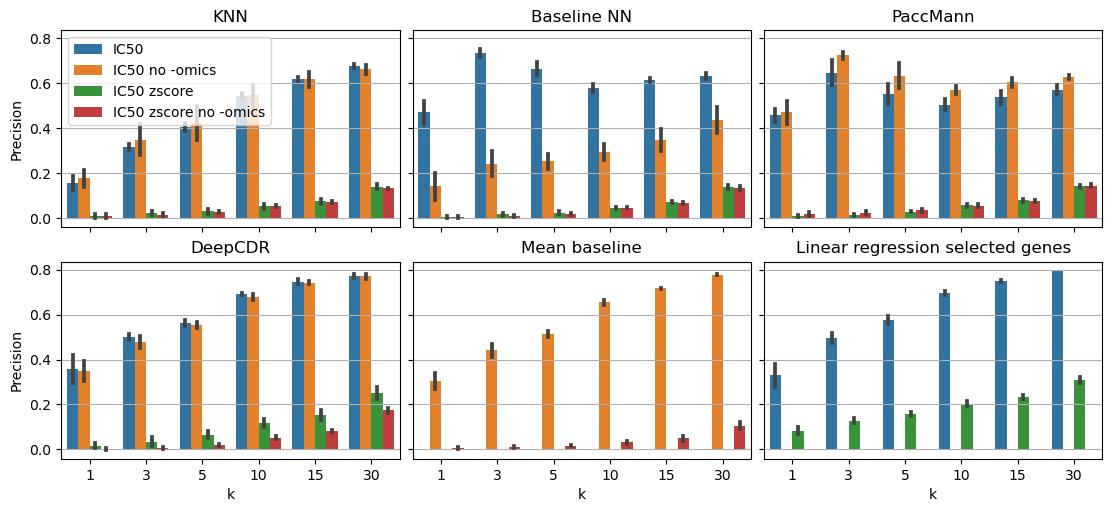

In [167]:
rel_ranking_res = ranking_eval[(ranking_eval.model.isin(['deepCDR', 'knn', 'mean_baseline', 
                                                                      'lin_reg_feat_sel', 'paccmann',
       'baseline_nn']) & ranking_eval.drug_response.isin(['IC50', 'IC50_zscore']))]
rel_ranking_res = rel_ranking_res[(rel_ranking_res.model!='lin_reg_feat_sel')|(rel_ranking_res.genes!='PaccMann genes')]
rel_ranking_res = rel_ranking_res.replace({'deepCDR': 'DeepCDR', 'paccmann': 'PaccMann',
                                                   'baseline_nn': 'Baseline NN', 'mean_baseline': 'Mean baseline',
                                                   'lin_reg_feat_sel': 'Linear regression selected genes', 'knn': 'KNN',
                                                   'IC50_zscore': 'IC50 zscore'})
for (dr, g), rows in rel_ranking_res.groupby(['drug_response', 'genes']):
    if g == 'no RNAseq': rel_ranking_res.loc[rows.index, 'label'] = dr + ' no -omics'
    else: rel_ranking_res.loc[rows.index, 'label'] = dr
        
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11,5), constrained_layout=True, 
                        sharey=True, sharex=True)
axs = axs.ravel()
X = ks
X_axis = np.arange(len(X))

for i, model in enumerate(['KNN', 'Baseline NN', 'PaccMann', 'DeepCDR', 'Mean baseline', 'Linear regression selected genes']): 
    data = rel_ranking_res[rel_ranking_res.model == model]
    if model == 'Mean baseline':
        append_IC50_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 'label': ['IC50']*len(ks),
                                 'prec': [0.0]*len(ks)})
        append_IC50zscore_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 
                                             'label': ['IC50 zscore']*len(ks),
                                             'prec': [0.0]*len(ks)})
        data = pd.concat([append_IC50_df, data[data.label=='IC50 no -omics'], append_IC50zscore_df, data[data.label=='IC50 zscore no -omics']])
    elif model == 'Linear regression selected genes':
        append_IC50_no_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 'label': ['IC50 no -omic']*len(ks),
                                 'prec': [0.0]*len(ks)})
        append_IC50zscore_no_df = pd.DataFrame({'k': ks, 'model': [model] * len(ks), 
                                             'label': ['IC50 zscore no -omics']*len(ks),
                                             'prec': [0.0]*len(ks)})
        data = pd.concat([data[data.label=='IC50'], append_IC50_no_df, data[data.label=='IC50 zscore'], append_IC50zscore_no_df])
    
    sns.barplot(x="k", y="prec", hue="label", data=data, ax = axs[i], 
            errorbar = 'sd')
    
    axs[i].set_title(model)
    axs[i].set_xticks(X_axis, X)
    if i==0 or i==3: axs[i].set_ylabel("Precision")
    else: axs[i].set_ylabel(None)
    if i>2: axs[i].set_xlabel("k")
    else: axs[i].set_xlabel(None)
    axs[i].grid(axis='y')
    if i==0: axs[i].legend(title=None)
    else: axs[i].get_legend().remove()
        
plt.savefig('figures/results/GDSC/GDSC_models_ranking.png', facecolor = 'white', transparent = False, 
            dpi=500, bbox_inches='tight')

In [48]:
counter = 0
mse_pearson_res_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean'])

for (model, drug_response, genes), rows in mse_pearson_eval_per_drug.groupby(['model', 'drug_response', 'genes']):
    mse_pearson_res_per_drug.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), 
                              np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval)
                            ]
    counter+=1
mse_pearson_res_per_drug.to_csv('tables/results/GDSC/gdsc_mse_pearson_per_drug.csv')
mse_pearson_res_per_drug

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean
0,baseline_nn,IC50,PaccMann genes,7.060947,0.356532,0.159446,0.024876,0.027067,0.012105,0.519427
1,baseline_nn,IC50,no RNAseq,3.274661,0.133009,0.059483,NaN,NaN,NaN,NaN
2,baseline_nn,IC50_zscore,PaccMann genes,1.324197,0.091444,0.040895,0.016811,0.030035,0.013432,0.498617
3,baseline_nn,IC50_zscore,no RNAseq,1.116797,0.057449,0.025692,NaN,NaN,NaN,NaN
4,deepCDR,IC50,DeepCDR genes,2.064163,0.087234,0.039012,0.299675,0.034752,0.015541,0.100394
5,deepCDR,IC50,no RNAseq,2.156303,0.145480,0.065061,NaN,NaN,NaN,NaN
6,deepCDR,IC50_zscore,DeepCDR genes,0.950568,0.030629,0.013698,0.319944,0.018533,0.008288,0.087947
7,deepCDR,IC50_zscore,no RNAseq,1.022443,0.055931,0.025013,NaN,NaN,NaN,NaN
8,knn,IC50,PaccMann genes,3.732895,0.013347,0.005969,0.028888,0.010571,0.004727,0.497557
9,knn,IC50,no RNAseq,3.723531,0.191661,0.085713,NaN,NaN,NaN,NaN
